# Hough transform with grids 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


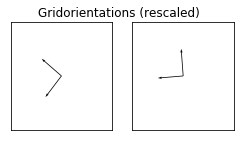

In [1225]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from htmresearch.support.gridcells.mdist.utils import *
%load_ext autoreload
%autoreload 2


m = 2
S = np.ones(m)*1.
# S = np.random.normal(1.,.1, size=m)
# S = np.sqrt(2)**np.arange(m)
k = 2
B, V, S = create_kd_hyper_module(m, k, scale=S)
V = np.zeros((m,2))
A = create_action_tensor(B)


        
fig, ax = plt.subplots(1, m, figsize=(2*m, 2));
plt.suptitle("Gridorientations (rescaled)")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=None)

for i in range(m):
    ax[i].set_xlim(-2,2)
    ax[i].set_ylim(-2,2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    r1 = B[i,0,:] / S[i]
    r2 = B[i,1,:] / S[i]

    ax[i].quiver(0.0,0.0,r1[:2],r2[:2], angles='xy', scale_units='xy', scale=1)



    
def evolve(Delta, object_id):
    
    
    f = Features[object_id, 0]
    Q = Pinned_phases[f]
    
    
    p = np.random.sample((1, m, 2))
    P = np.repeat(p, Q.shape[0], axis=0)
    
    G = geod_on_hypertorus(P, Q)

    force = np.mean(G, axis=0)
    p = apply_velocity(p, force)


    for i in range(1, num_fo):
#     for i in range(1, 5):
        phase_vel = pipe_through_tensor(A, Delta[[i-1]])
        p = apply_velocity(p, phase_vel)

        f = Features[oid, i]
        Q = Pinned_phases[f]

        P = np.repeat(p, Q.shape[0], axis=0)

        G = geod_on_hypertorus(P,Q)

        force = np.mean(G, axis=0)
        p = apply_velocity(p, force)

    P = np.repeat(p, num_o, axis=0)

#     Q = Object_codes[:,i,:,:]
    Q = Anchors[:,0,:,:]
#     ds = M_dist(P, Q, S=S)
    ds = M_dist_comp(P, Q, S=S)[:,0]

    
    success = (object_id == np.argmin(ds))
    return success, ds

In [1226]:

num_o  = 20
num_fo = 5
num_f  = 1


Objects  = (np.random.sample((num_o, num_fo, 2))-0.5)*200.1
Features = np.random.randint(num_f, size=(num_o, num_fo)) 


# Creating object codes randomly anchored
# within the hypertorus
# R = np.random.sample((num_o, 2))*30.
# Anchors = pipe_through_tensor(A, R).reshape((num_o, 1, m, 2))
Anchors      = np.random.sample((num_o, 1, m, 2))
Object_codes = np.zeros((num_o, num_fo, m, 2))
for o in range(num_o):        
        Object_codes[o] = map_to_hypertorus(B, V, Objects[o])

Object_codes += Anchors
Object_codes %= 1.0


Pinned_phases = []
for i in range(num_f):
    Pinned_phases.append([])



for i in range(num_o):  
    for j in range(num_fo):
        f = Features[i,j]
        code = Object_codes[i,j][:,:]
        Pinned_phases[f].append(code)


for i in range(num_f):
    Pinned_phases[i] = np.array(Pinned_phases[i])
        

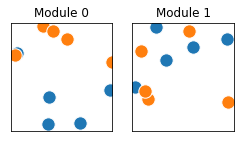

In [1227]:
fig, ax = plt.subplots(1, m, figsize=(2*m, 2));

p = Object_codes[0]
q = Object_codes[1]

for i in range(m):
    ax[i].set_xlim(0,1)
    ax[i].set_ylim(0,1)

    ax[i].set_xticks([])
    ax[i].set_yticks([])

    
    ax[i].scatter(p[:,i,0],p[:,i,1], edgecolor='white', s= 180.)
    ax[i].scatter(q[:,i,0],q[:,i,1],   edgecolor='white', s= 180.)

    ax[i].set_title("Module {}".format(i))

plt.show()

Pure chance: 5.0
Grid model: 2.0


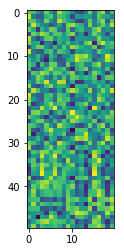

In [1228]:
num_runs = 50
results = []

oid = 0 
Delta = Objects[oid, 1:,:] - Objects[oid, :-1,:]

ds = np.zeros((num_runs, num_o))
results = np.zeros(num_runs)
for i in range(num_runs):
    success, dist = evolve(Delta, oid)
    ds[i] = dist
    results[i] = success*1.0

print "Pure chance:", 100.0/num_o
print "Grid model:", sum(results)*100.0/num_runs

plt.imshow(ds)


Mean distance, correct: 0.0693597946619
Mean distance, wrong: 0.336856940143


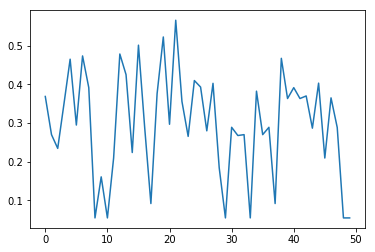

In [1211]:
plt.plot(ds[:,0])
ds = ds[:,0]
print "Mean distance, correct:", np.mean([ ds[i] for i in range(len(ds)) if results[i]==1.  ])
print "Mean distance, wrong:"  , np.mean([ ds[i] for i in range(len(ds)) if results[i]==0.  ])
